# Imports

In [1]:
from pathlib import Path
import numpy as np
import torch
import math
from tqdm import tqdm
from torchvision.datasets import CocoDetection
import matplotlib.pyplot as plt
import torchvision

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from abbyy_course_cvdl_t3.coco_text import COCO_Text
from abbyy_course_cvdl_t3 import coco_evaluation
from abbyy_course_cvdl_t3.utils import evaluate_ap_from_cocotext_json
from abbyy_course_cvdl_t3.utils import dump_detections_to_cocotext_json

In [3]:
cd ../task2

/home/avashchilko/abbyy9sem/course_cvdl/task2


In [4]:
import abbyy_course_cvdl_t2
from abbyy_course_cvdl_t2.convert import PointsToObjects, ObjectsToPoints
from abbyy_course_cvdl_t2.impl.train import train
from abbyy_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform
from abbyy_course_cvdl_t2.network import CenterNet
from abbyy_course_cvdl_t2.loss import CenterNetLoss

In [5]:
cd ../task3

/home/avashchilko/abbyy9sem/course_cvdl/task3


In [6]:
device = torch.device('cuda:3')

# Data

In [7]:
base = Path("/home/avashchilko/coco2014")
anno_path = base / 'cocotext.v2.json'
images_path = base / 'train'

assert anno_path.exists(), "Set your own path to annotation"
assert images_path.exists(), "Set your own path to images"


In [8]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:01.918360
creating index...
index created!


In [9]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]
        img[
                yc - hy//2 - thick : yc - hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val
        img[
                yc + hy//2 - thick : yc + hy//2 + thick, 
                xc - wx//2 : xc + wx//2, 
        ] = val

        img[
                yc - hy//2 : yc + hy//2, 
                (xc - wx//2 - thick): (xc - wx//2 + thick), 
        ] = val
        img[
                yc - hy//2 : yc + hy//2, 
                xc + wx//2 - thick: xc + wx//2 + thick, 
        ] = val
    return img
        
        

In [10]:
n_classes = 2
input_shape = (640, 640)

In [11]:
ds_train = CocoTextDetection(
    images_path,
    anno_path,
    transforms=CocoDetectionPrepareTransform(size=input_shape, #ids_map = {1: 0, 0: 0}
),
    area_fraction_threshold=1/32/32
)

In [12]:
ds_val = CocoTextDetection(
    images_path,
    anno_path,
    transforms=CocoDetectionPrepareTransform(size=input_shape, #ids_map = {1: 0, 0: 0}
    ),
    area_fraction_threshold=1/32/32,
    split='val'
)

In [13]:
x, y = ds_train[6]

In [14]:
y[:10]

tensor([[334.7333, 151.4000,  31.3333,  33.6000,   1.0000,   1.0000],
        [328.8000, 391.9500,  28.8000,  49.7000,   1.0000,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])

In [15]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=2, shuffle=True
)

In [16]:
valloader = torch.utils.data.DataLoader(
    ds_val, batch_size=1, shuffle=False
)

# Learning

In [17]:
net = CenterNet(pretrained="resnet34", head_kwargs={'c_classes': n_classes}, nms_kwargs={'kernel_size': 5})
crit = CenterNetLoss(obj_to_points=ObjectsToPoints(num_classes=n_classes, hw=160))#, l_size_lambda=3)

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
net = train(ds_train, net=net, criterion=crit, batch_size=64, epochs=150, device=torch.device(device), lr=1e-3)

epoch 0|0; total loss:164.18885803222656
last losses: [4924.083984375, 0.2887943983078003, 1.2930536270141602]
epoch 0|30; total loss:226.2421112060547
last losses: [2.558324098587036, 0.2526053786277771, 0.5414556264877319]
epoch 0|60; total loss:3.341874361038208
last losses: [2.119999408721924, 0.21389275789260864, 0.47911566495895386]
epoch 0|90; total loss:3.347109079360962
last losses: [2.7838408946990967, 0.2856873869895935, 0.6705633401870728]
epoch 0|120; total loss:3.2230467796325684
last losses: [2.195244312286377, 0.2564937472343445, 0.6204767227172852]
epoch 0|150; total loss:3.0660927295684814
last losses: [2.2251346111297607, 0.2700366675853729, 0.574112057685852]
epoch 0|180; total loss:2.8715438842773438
last losses: [1.9607528448104858, 0.26137882471084595, 0.5317432880401611]
epoch 0|210; total loss:2.6699507236480713
last losses: [1.9307962656021118, 0.28413277864456177, 0.8102740049362183]
epoch 0|240; total loss:2.614567279815674
last losses: [1.687021017074585, 0

epoch 7|30; total loss:1.2262694835662842
last losses: [0.6088614463806152, 0.1854126751422882, 0.23275786638259888]
epoch 7|60; total loss:1.2563607692718506
last losses: [0.7729315757751465, 0.215969979763031, 0.298244833946228]
epoch 7|90; total loss:1.2062731981277466
last losses: [0.656129777431488, 0.2478242814540863, 0.23122434318065643]
epoch 7|120; total loss:1.228202223777771
last losses: [0.6771290302276611, 0.22372350096702576, 0.24918918311595917]
epoch 7|150; total loss:1.1671607494354248
last losses: [0.6095807552337646, 0.18251287937164307, 0.16838377714157104]
epoch 7|180; total loss:1.1891800165176392
last losses: [0.670529842376709, 0.21372441947460175, 0.22306537628173828]
epoch 7|210; total loss:1.2294152975082397
last losses: [0.6813089847564697, 0.19881771504878998, 0.2636590003967285]
epoch 7|240; total loss:1.208996295928955
last losses: [0.7587491869926453, 0.2410312294960022, 0.30331626534461975]
epoch 7|270; total loss:1.185523271560669
last losses: [0.78231

epoch 14|30; total loss:0.693619966506958
last losses: [0.27108150720596313, 0.15574106574058533, 0.15153706073760986]
epoch 14|60; total loss:0.718428909778595
last losses: [0.3190262019634247, 0.17197634279727936, 0.14375054836273193]
epoch 14|90; total loss:0.6862515211105347
last losses: [0.29111310839653015, 0.18338868021965027, 0.17275455594062805]
epoch 14|120; total loss:0.7405237555503845
last losses: [0.3552560806274414, 0.17264865338802338, 0.1732361912727356]
epoch 14|150; total loss:0.7403942942619324
last losses: [0.28370463848114014, 0.15468564629554749, 0.10946370661258698]
epoch 14|180; total loss:0.7581024765968323
last losses: [0.3325939178466797, 0.1654735505580902, 0.13040779531002045]
epoch 14|210; total loss:0.7746595144271851
last losses: [0.36888426542282104, 0.19921623170375824, 0.156249538064003]
epoch 14|240; total loss:0.7851426601409912
last losses: [0.43726831674575806, 0.20788145065307617, 0.140735924243927]
epoch 14|270; total loss:0.767894983291626
las

epoch 21|0; total loss:0.01388916652649641
last losses: [0.1802261918783188, 0.13746756315231323, 0.09898123145103455]
epoch 21|30; total loss:0.522500216960907
last losses: [0.16090509295463562, 0.1487073302268982, 0.09929893165826797]
epoch 21|60; total loss:0.5244659185409546
last losses: [0.20928241312503815, 0.16669729351997375, 0.17090663313865662]
epoch 21|90; total loss:0.5211312174797058
last losses: [0.22658032178878784, 0.18514616787433624, 0.14927424490451813]
epoch 21|120; total loss:0.5252783894538879
last losses: [0.24328172206878662, 0.18637701869010925, 0.14166566729545593]
epoch 21|150; total loss:0.5431497693061829
last losses: [0.2714597284793854, 0.1925567388534546, 0.13292893767356873]
epoch 21|180; total loss:0.5459191799163818
last losses: [0.20008713006973267, 0.17029573023319244, 0.118273064494133]
epoch 21|210; total loss:0.5528563857078552
last losses: [0.23106428980827332, 0.15807949006557465, 0.13221435248851776]
epoch 21|240; total loss:0.5526526570320129

epoch 27|270; total loss:0.47102317214012146
last losses: [0.18812629580497742, 0.1784525215625763, 0.11537894606590271]
epoch 28|0; total loss:0.016915854066610336
last losses: [0.18431267142295837, 0.1681864857673645, 0.15497642755508423]
epoch 28|30; total loss:0.4825674295425415
last losses: [0.15214119851589203, 0.1693466454744339, 0.1027851477265358]
epoch 28|60; total loss:0.4531440734863281
last losses: [0.1723206341266632, 0.14670056104660034, 0.1084323450922966]
epoch 28|90; total loss:0.4520706534385681
last losses: [0.18355990946292877, 0.19813112914562225, 0.15221314132213593]
epoch 28|120; total loss:0.46537983417510986
last losses: [0.16752450168132782, 0.1658748984336853, 0.1520359218120575]
epoch 28|150; total loss:0.44743338227272034
last losses: [0.1649179905653, 0.16326172649860382, 0.11001749336719513]
epoch 28|180; total loss:0.45282524824142456
last losses: [0.17375671863555908, 0.16897040605545044, 0.11538833379745483]
epoch 28|210; total loss:0.4455231726169586

epoch 34|240; total loss:0.36924034357070923
last losses: [0.0882314071059227, 0.14049787819385529, 0.0934261828660965]
epoch 34|270; total loss:0.37155210971832275
last losses: [0.12830780446529388, 0.15452530980110168, 0.10598991811275482]
epoch 35|0; total loss:0.01431518979370594
last losses: [0.1236792504787445, 0.173242449760437, 0.1325339674949646]
epoch 35|30; total loss:0.35891664028167725
last losses: [0.09904336929321289, 0.13359811902046204, 0.10921825468540192]
epoch 35|60; total loss:0.34503793716430664
last losses: [0.1270502209663391, 0.16751986742019653, 0.13695544004440308]
epoch 35|90; total loss:0.3547150194644928
last losses: [0.11023230105638504, 0.16946181654930115, 0.1074465960264206]
epoch 35|120; total loss:0.35216251015663147
last losses: [0.10390971601009369, 0.14624793827533722, 0.09398584067821503]
epoch 35|150; total loss:0.35631418228149414
last losses: [0.10653940588235855, 0.1588951051235199, 0.10214855521917343]
epoch 35|180; total loss:0.356494188308

epoch 41|210; total loss:0.2965766191482544
last losses: [0.07886052131652832, 0.11432507634162903, 0.08870065212249756]
epoch 41|240; total loss:0.2934825122356415
last losses: [0.06426237523555756, 0.14713099598884583, 0.08782459050416946]
epoch 41|270; total loss:0.3127822279930115
last losses: [0.09607627242803574, 0.16123318672180176, 0.1174306645989418]
epoch 42|0; total loss:0.010911818593740463
last losses: [0.07377322018146515, 0.1442057192325592, 0.10937561094760895]
epoch 42|30; total loss:0.31016966700553894
last losses: [0.0790313109755516, 0.14178723096847534, 0.08606089651584625]
epoch 42|60; total loss:0.3078940510749817
last losses: [0.0960051491856575, 0.1597808301448822, 0.10406873375177383]
epoch 42|90; total loss:0.30813297629356384
last losses: [0.07208426296710968, 0.13616932928562164, 0.08802057802677155]
epoch 42|120; total loss:0.30146461725234985
last losses: [0.08718566596508026, 0.15931640565395355, 0.08985279500484467]
epoch 42|150; total loss:0.3062382936

epoch 48|150; total loss:0.2686883807182312
last losses: [0.04533147066831589, 0.12407569587230682, 0.08137454092502594]
epoch 48|180; total loss:0.2774209678173065
last losses: [0.06977525353431702, 0.13341861963272095, 0.11359314620494843]
epoch 48|210; total loss:0.2608020007610321
last losses: [0.052649930119514465, 0.11690689623355865, 0.06534881144762039]
epoch 48|240; total loss:0.2722761631011963
last losses: [0.09107713401317596, 0.10863874852657318, 0.0834692046046257]
epoch 48|270; total loss:0.2730183005332947
last losses: [0.04660928621888161, 0.11794790625572205, 0.06036671996116638]
epoch 49|0; total loss:0.008802082389593124
last losses: [0.05579802393913269, 0.12213416397571564, 0.086130291223526]
epoch 49|30; total loss:0.28432223200798035
last losses: [0.047897759824991226, 0.13422314822673798, 0.09455858916044235]
epoch 49|60; total loss:0.28230488300323486
last losses: [0.05071326345205307, 0.1096653938293457, 0.06515578925609589]
epoch 49|90; total loss:0.26877737

epoch 55|90; total loss:0.2279403656721115
last losses: [0.03466784581542015, 0.10027170181274414, 0.07186240702867508]
epoch 55|120; total loss:0.2333601415157318
last losses: [0.03117820806801319, 0.12700633704662323, 0.10316188633441925]
epoch 55|150; total loss:0.22117096185684204
last losses: [0.03779489919543266, 0.1075589582324028, 0.06560277938842773]
epoch 55|180; total loss:0.22342641651630402
last losses: [0.03939998894929886, 0.12241219729185104, 0.07062016427516937]
epoch 55|210; total loss:0.22641673684120178
last losses: [0.036594096571207047, 0.13173219561576843, 0.09982366859912872]
epoch 55|240; total loss:0.22197914123535156
last losses: [0.04133409634232521, 0.1082954853773117, 0.0789986103773117]
epoch 55|270; total loss:0.21456098556518555
last losses: [0.036008432507514954, 0.10544323921203613, 0.07680289447307587]
epoch 56|0; total loss:0.006426539272069931
last losses: [0.021594762802124023, 0.10415362566709518, 0.06704777479171753]
epoch 56|30; total loss:0.21

epoch 62|30; total loss:0.2370927482843399
last losses: [0.05293465405702591, 0.09711133688688278, 0.10143059492111206]
epoch 62|60; total loss:0.2267412394285202
last losses: [0.042272165417671204, 0.11974947154521942, 0.06909476220607758]
epoch 62|90; total loss:0.21902354061603546
last losses: [0.038022641092538834, 0.09736946225166321, 0.062401995062828064]
epoch 62|120; total loss:0.21455208957195282
last losses: [0.023329291492700577, 0.10117942094802856, 0.059689052402973175]
epoch 62|150; total loss:0.2237720638513565
last losses: [0.03236303851008415, 0.11057417839765549, 0.0723014771938324]
epoch 62|180; total loss:0.21678043901920319
last losses: [0.03040972165763378, 0.11800430715084076, 0.0685194879770279]
epoch 62|210; total loss:0.2078668773174286
last losses: [0.03666529804468155, 0.1148500069975853, 0.07219073176383972]
epoch 62|240; total loss:0.2149088978767395
last losses: [0.03714852035045624, 0.10566138476133347, 0.06322439014911652]
epoch 62|270; total loss:0.221

epoch 68|270; total loss:0.17625994980335236
last losses: [0.010446758009493351, 0.09436739981174469, 0.06376941502094269]
epoch 69|0; total loss:0.006041951477527618
last losses: [0.013559497892856598, 0.09407919645309448, 0.07361983507871628]
epoch 69|30; total loss:0.18651707470417023
last losses: [0.014619322493672371, 0.09824249893426895, 0.06599578261375427]
epoch 69|60; total loss:0.18891483545303345
last losses: [0.02075204811990261, 0.09762873500585556, 0.07235467433929443]
epoch 69|90; total loss:0.18018372356891632
last losses: [0.01660092920064926, 0.09582442045211792, 0.05999574065208435]
epoch 69|120; total loss:0.1894358992576599
last losses: [0.023566309362649918, 0.10276061296463013, 0.07893244922161102]
epoch 69|150; total loss:0.1720738410949707
last losses: [0.011953466571867466, 0.09835817664861679, 0.08095604181289673]
epoch 69|180; total loss:0.18769727647304535
last losses: [0.012187176384031773, 0.07613728940486908, 0.06781196594238281]
epoch 69|210; total loss

epoch 75|210; total loss:0.16885247826576233
last losses: [0.008329154923558235, 0.08712724596261978, 0.0643768385052681]
epoch 75|240; total loss:0.16950689256191254
last losses: [0.020347334444522858, 0.08256565779447556, 0.06940217316150665]
epoch 75|270; total loss:0.16497141122817993
last losses: [0.01362682320177555, 0.08057615160942078, 0.050973694771528244]
epoch 76|0; total loss:0.004897025413811207
last losses: [0.023406842723488808, 0.06962999701499939, 0.05387391149997711]
epoch 76|30; total loss:0.17208918929100037
last losses: [0.04367613047361374, 0.07481850683689117, 0.0454079732298851]
epoch 76|60; total loss:0.17382138967514038
last losses: [0.028071271255612373, 0.10606162250041962, 0.060333363711833954]
epoch 76|90; total loss:0.16972407698631287
last losses: [0.03363220393657684, 0.08182365447282791, 0.05043826624751091]
epoch 76|120; total loss:0.1622834950685501
last losses: [0.021012648940086365, 0.09421374648809433, 0.0906311646103859]
epoch 76|150; total loss:

epoch 82|150; total loss:0.1438332051038742
last losses: [0.012208007276058197, 0.06357476115226746, 0.04907888174057007]
epoch 82|180; total loss:0.14631229639053345
last losses: [0.018870215862989426, 0.08728515356779099, 0.0548492893576622]
epoch 82|210; total loss:0.43200480937957764
last losses: [0.4335562586784363, 0.17907419800758362, 0.18742786347866058]
epoch 82|240; total loss:0.524490475654602
last losses: [0.19694551825523376, 0.14077100157737732, 0.11529571563005447]
epoch 82|270; total loss:0.3506758511066437
last losses: [0.10379733890295029, 0.10004651546478271, 0.07247146964073181]
epoch 83|0; total loss:0.007281034719198942
last losses: [0.057512205094099045, 0.09304384887218475, 0.067874975502491]
epoch 83|30; total loss:0.2264368236064911
last losses: [0.047819584608078, 0.08914541453123093, 0.06899745017290115]
epoch 83|60; total loss:0.2238367348909378
last losses: [0.06183556839823723, 0.09216569364070892, 0.07855473458766937]
epoch 83|90; total loss:0.2043681889

epoch 89|60; total loss:0.11440658569335938
last losses: [0.008831161074340343, 0.06180841103196144, 0.04652826860547066]
epoch 89|90; total loss:0.12412387877702713
last losses: [0.002959560602903366, 0.054013848304748535, 0.04918083921074867]
epoch 89|120; total loss:0.11821424961090088
last losses: [0.005432216916233301, 0.0643971785902977, 0.051857396960258484]
epoch 89|150; total loss:0.1261201798915863
last losses: [0.006843199022114277, 0.054584551602602005, 0.04239992797374725]
epoch 89|180; total loss:0.1233941838145256
last losses: [0.006189038045704365, 0.060812368988990784, 0.0566265769302845]
epoch 89|210; total loss:0.12368453294038773
last losses: [0.01016357634216547, 0.059466563165187836, 0.04422102868556976]
epoch 89|240; total loss:0.11967761069536209
last losses: [0.020356176421046257, 0.07086719572544098, 0.0554674006998539]
epoch 89|270; total loss:0.12463987618684769
last losses: [0.00810481421649456, 0.06066837161779404, 0.046243686228990555]
epoch 90|0; total l

epoch 95|270; total loss:0.1499582827091217
last losses: [0.025516506284475327, 0.07489625364542007, 0.07259663939476013]
epoch 96|0; total loss:0.005219294223934412
last losses: [0.015694618225097656, 0.05570082366466522, 0.08518338203430176]
epoch 96|30; total loss:0.14220111072063446
last losses: [0.012806941755115986, 0.07074261456727982, 0.051066141575574875]
epoch 96|60; total loss:0.1254470944404602
last losses: [0.004512599669396877, 0.0598297044634819, 0.04842819646000862]
epoch 96|90; total loss:0.14320088922977448
last losses: [0.019386518746614456, 0.05853499472141266, 0.05387812480330467]
epoch 96|120; total loss:0.1638844758272171
last losses: [0.04288275167346001, 0.07171812653541565, 0.07436329126358032]
epoch 96|150; total loss:0.1432066112756729
last losses: [0.01753167435526848, 0.06808862090110779, 0.060508426278829575]
epoch 96|180; total loss:0.14317038655281067
last losses: [0.021494735032320023, 0.07182705402374268, 0.0565151646733284]
epoch 96|210; total loss:0

epoch 102|180; total loss:0.11441787332296371
last losses: [0.0018217700999230146, 0.04673641175031662, 0.036491647362709045]
epoch 102|210; total loss:0.11230746656656265
last losses: [0.0025603678077459335, 0.05013754591345787, 0.044949114322662354]
epoch 102|240; total loss:0.11739583313465118
last losses: [0.009271611459553242, 0.054569512605667114, 0.04955368489027023]
epoch 102|270; total loss:0.11136381328105927
last losses: [0.002539820736274123, 0.05882012099027634, 0.053929321467876434]
epoch 103|0; total loss:0.00326006137765944
last losses: [0.0023038526996970177, 0.04488265514373779, 0.05061532184481621]
epoch 103|30; total loss:0.11671900749206543
last losses: [0.008213621564209461, 0.06425097584724426, 0.04074186086654663]
epoch 103|60; total loss:0.11608750373125076
last losses: [0.005668041296303272, 0.060752905905246735, 0.03839994966983795]
epoch 103|90; total loss:0.11098016798496246
last losses: [0.0033949255011975765, 0.055060647428035736, 0.04907688871026039]
epo

epoch 109|90; total loss:0.10855022817850113
last losses: [0.004614129196852446, 0.05516224354505539, 0.04830333590507507]
epoch 109|120; total loss:0.10758654773235321
last losses: [0.004342078696936369, 0.053270772099494934, 0.03882451355457306]
epoch 109|150; total loss:0.10839004069566727
last losses: [0.0017104074358940125, 0.049358874559402466, 0.05100205913186073]
epoch 109|180; total loss:0.11143317073583603
last losses: [0.005321040283888578, 0.06939693540334702, 0.06671755015850067]
epoch 109|210; total loss:0.36176714301109314
last losses: [0.14092595875263214, 0.09176924079656601, 0.06957575678825378]
epoch 109|240; total loss:0.34510114789009094
last losses: [0.07283275574445724, 0.07015572488307953, 0.07871535420417786]
epoch 109|270; total loss:0.24529938399791718
last losses: [0.04645061492919922, 0.08491712808609009, 0.08391467481851578]
epoch 110|0; total loss:0.0046978238970041275
last losses: [0.015377727337181568, 0.06242824345827103, 0.06312873959541321]
epoch 110

epoch 115|270; total loss:0.08802252262830734
last losses: [0.006242177914828062, 0.03651489317417145, 0.032220106571912766]
epoch 116|0; total loss:0.003232745686545968
last losses: [0.0040210518054664135, 0.04427189379930496, 0.04868942126631737]
epoch 116|30; total loss:0.09017030894756317
last losses: [0.0014326059026643634, 0.04893345385789871, 0.06285019218921661]
epoch 116|60; total loss:0.0840534120798111
last losses: [0.0022663346026092768, 0.04408041387796402, 0.03471885249018669]
epoch 116|90; total loss:0.09266272932291031
last losses: [0.03090568631887436, 0.048408351838588715, 0.03959163278341293]
epoch 116|120; total loss:0.09120970964431763
last losses: [0.006858111824840307, 0.041047435253858566, 0.04800833761692047]
epoch 116|150; total loss:0.09043523669242859
last losses: [0.0012951688840985298, 0.03427891805768013, 0.04267304390668869]
epoch 116|180; total loss:0.08921752125024796
last losses: [0.0017469929298385978, 0.04661983996629715, 0.03485796973109245]
epoch 

epoch 122|180; total loss:0.09252616763114929
last losses: [0.00580282136797905, 0.04880230873823166, 0.04791245982050896]
epoch 122|210; total loss:0.08975844830274582
last losses: [0.002555395942181349, 0.04530991241335869, 0.04226113483309746]
epoch 122|240; total loss:0.09245384484529495
last losses: [0.00400504469871521, 0.046160049736499786, 0.03753111511468887]
epoch 122|270; total loss:0.09234574437141418
last losses: [0.0008850563317537308, 0.03362983465194702, 0.04363659769296646]
epoch 123|0; total loss:0.002788499230518937
last losses: [0.0029702256433665752, 0.04055362567305565, 0.04013111814856529]
epoch 123|30; total loss:0.09274103492498398
last losses: [0.0023142225109040737, 0.04836409166455269, 0.04262155294418335]
epoch 123|60; total loss:0.09033036231994629
last losses: [0.002240082249045372, 0.039835650473833084, 0.04745608940720558]
epoch 123|90; total loss:0.09378921240568161
last losses: [0.0014370143180713058, 0.04009590670466423, 0.04187636822462082]
epoch 12

epoch 129|90; total loss:0.08223143965005875
last losses: [0.016044193878769875, 0.045262664556503296, 0.051843687891960144]
epoch 129|120; total loss:0.08923881500959396
last losses: [0.0007547341519966722, 0.039640288800001144, 0.04291320592164993]
epoch 129|150; total loss:0.09159114211797714
last losses: [0.006177053786814213, 0.04430360719561577, 0.037522271275520325]
epoch 129|180; total loss:0.09430257230997086
last losses: [0.014733460731804371, 0.04378149285912514, 0.04112779349088669]
epoch 129|210; total loss:0.08919858932495117
last losses: [0.0014125786256045103, 0.03444036841392517, 0.04002489522099495]
epoch 129|240; total loss:0.0868552178144455
last losses: [0.0025304327718913555, 0.0407855361700058, 0.040688350796699524]
epoch 129|270; total loss:0.08837196975946426
last losses: [0.0022056489251554012, 0.04006689414381981, 0.03146462142467499]
epoch 130|0; total loss:0.0035422982182353735
last losses: [0.005453535821288824, 0.0524575375020504, 0.048357874155044556]
ep

epoch 135|270; total loss:0.08625901490449905
last losses: [0.0026061537209898233, 0.036918025463819504, 0.03092414140701294]
epoch 136|0; total loss:0.002837423700839281
last losses: [0.0008378817001357675, 0.03711939603090286, 0.04716542735695839]
epoch 136|30; total loss:0.08048448711633682
last losses: [0.0015263946261256933, 0.03746454417705536, 0.06326860189437866]
epoch 136|60; total loss:0.07809164375066757
last losses: [0.0018101130845025182, 0.035920992493629456, 0.03655509278178215]
epoch 136|90; total loss:0.07805395871400833
last losses: [0.0010825095232576132, 0.04293268173933029, 0.04263961687684059]
epoch 136|120; total loss:0.08220716565847397
last losses: [0.007085444871336222, 0.04185527190566063, 0.03876355290412903]
epoch 136|150; total loss:0.07902278751134872
last losses: [0.0016469882102683187, 0.04646643251180649, 0.046510711312294006]
epoch 136|180; total loss:0.07808241993188858
last losses: [0.000768717029131949, 0.03411436080932617, 0.02674242854118347]
epo

epoch 142|150; total loss:0.08949024975299835
last losses: [0.0035587120801210403, 0.029605641961097717, 0.035167403519153595]
epoch 142|180; total loss:0.08570872247219086
last losses: [0.009214432910084724, 0.041037969291210175, 0.038140080869197845]
epoch 142|210; total loss:0.08874712884426117
last losses: [0.002134519163519144, 0.03574064001441002, 0.03570155054330826]
epoch 142|240; total loss:0.08784106373786926
last losses: [0.004365659784525633, 0.04388059303164482, 0.05540931969881058]
epoch 142|270; total loss:0.08606795221567154
last losses: [0.001896262401714921, 0.04366391524672508, 0.044835396111011505]
epoch 143|0; total loss:0.0032579859253019094
last losses: [0.003522634506225586, 0.04497889429330826, 0.049238041043281555]
epoch 143|30; total loss:0.08367083221673965
last losses: [0.002351360395550728, 0.035159673541784286, 0.03456909582018852]
epoch 143|60; total loss:0.0761389508843422
last losses: [0.0020699838642030954, 0.03315543755888939, 0.03643001616001129]
ep

epoch 149|30; total loss:0.0896904468536377
last losses: [0.018489321693778038, 0.044262487441301346, 0.03818187862634659]
epoch 149|60; total loss:0.09013554453849792
last losses: [0.0017373309237882495, 0.042034395039081573, 0.04649242013692856]
epoch 149|90; total loss:0.082325778901577
last losses: [0.0053106192499399185, 0.03469982370734215, 0.03223995864391327]
epoch 149|120; total loss:0.08343234658241272
last losses: [0.006144871935248375, 0.04202916845679283, 0.03619988262653351]
epoch 149|150; total loss:0.08513691276311874
last losses: [0.002486551646143198, 0.033047839999198914, 0.04091334342956543]
epoch 149|180; total loss:0.0852593332529068
last losses: [0.002063402906060219, 0.0309799425303936, 0.03625006228685379]
epoch 149|210; total loss:0.08553683757781982
last losses: [0.005667483899742365, 0.046928636729717255, 0.040605492889881134]
epoch 149|240; total loss:0.08191148936748505
last losses: [0.00181009026709944, 0.03595730662345886, 0.04123690724372864]
epoch 149|

In [19]:
torch.save(net, 'centernet_resnet34_640.pth')

# Quality

## Postprocessing and visualization

In [20]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [21]:
net = torch.load('centernet_resnet34_640.pth')

In [22]:
net.to(device)
net.eval()

CenterNet(
  (backbone): ResnetBackbone(
    (downscale): HeadlessPretrainedResnet34Encoder(
      (md): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3)

In [23]:
x, y = ds_train[6]

with torch.no_grad():
    yp_heat = net(x[None].to(device)).cpu()    
    yp = net(x[None].to(device), return_objects=True).cpu()

class 0 heatmap


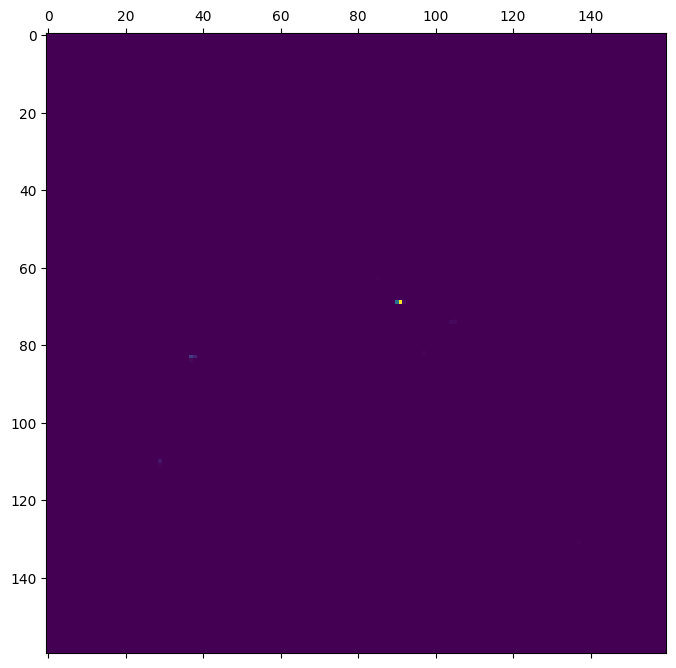

class 1 heatmap


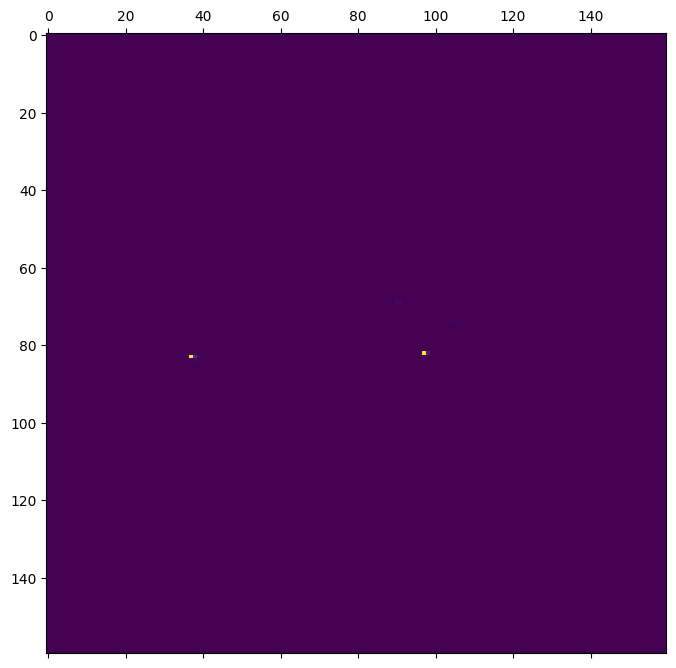

w_heatmap


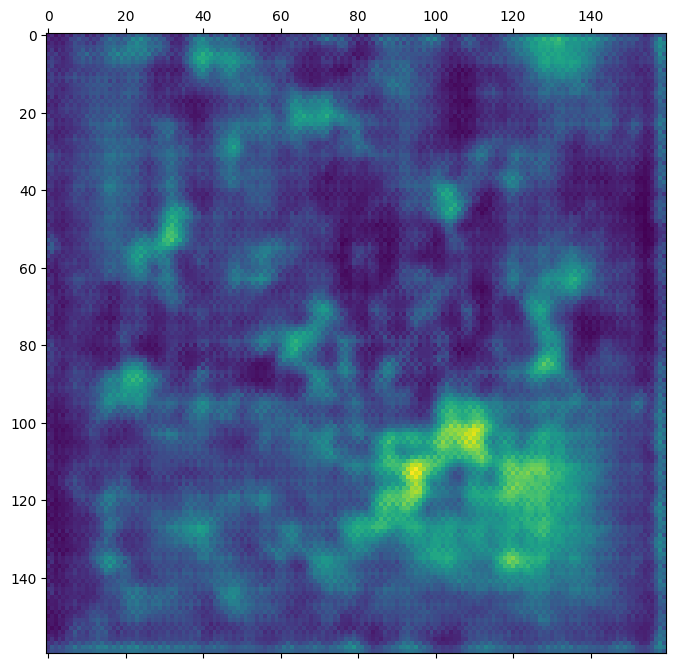

h heatmap


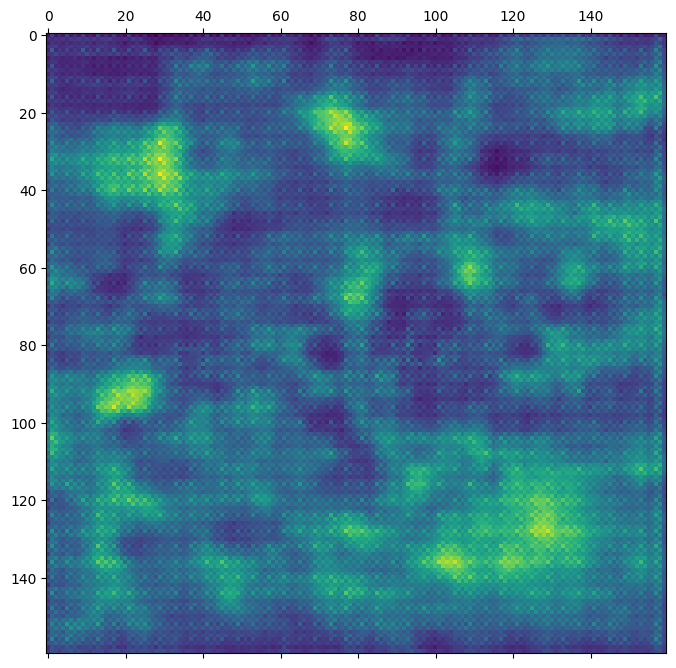

In [24]:
print('class 0 heatmap')
plt.matshow(yp_heat[0][0])
plt.show()

print('class 1 heatmap')
plt.matshow(yp_heat[0][1])
plt.show()

print('w_heatmap')
plt.matshow(yp_heat[0][-1])
plt.show()

print('h heatmap')
plt.matshow(yp_heat[0][-2])
plt.show()

In [25]:
def draw_boxes(image_np, yc_t, xc_t, hy_t, wx_t, color=(0, 255, 0), thick=1):
    img = np.array(image_np)
    num_boxes = len(yc_t)
    val = np.array(color)
    for idx in range(num_boxes):
        yc = yc_t[idx]
        xc = xc_t[idx]
        hy = hy_t[idx]
        wx = wx_t[idx]

        hyd2 = torch.div(hy, 2, rounding_mode='trunc')
        wxd2 = torch.div(wx, 2, rounding_mode='trunc')

        img[
                yc - hyd2 - thick : yc - hyd2 + thick, 
                xc - wxd2 : xc + wxd2, 
        ] = val
        img[
                yc + hyd2 - thick : yc + hyd2 + thick, 
                xc - wxd2 : xc + wxd2, 
        ] = val

        img[
                yc - hyd2 : yc + hyd2, 
                (xc - wxd2 - thick): (xc - wxd2 + thick), 
        ] = val
        img[
                yc - hyd2 : yc + hyd2, 
                xc + wxd2 - thick: xc + wxd2 + thick, 
        ] = val
    return img


rnd = lambda x: torch.round(x).long()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


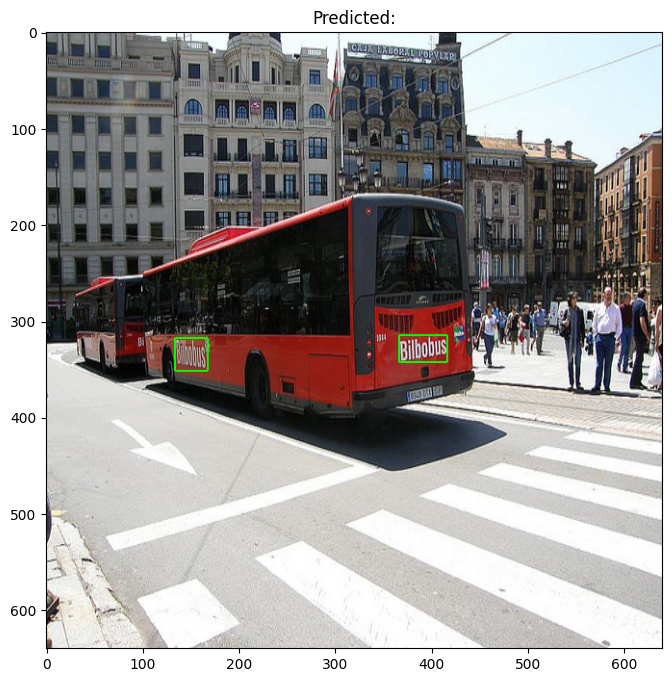

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


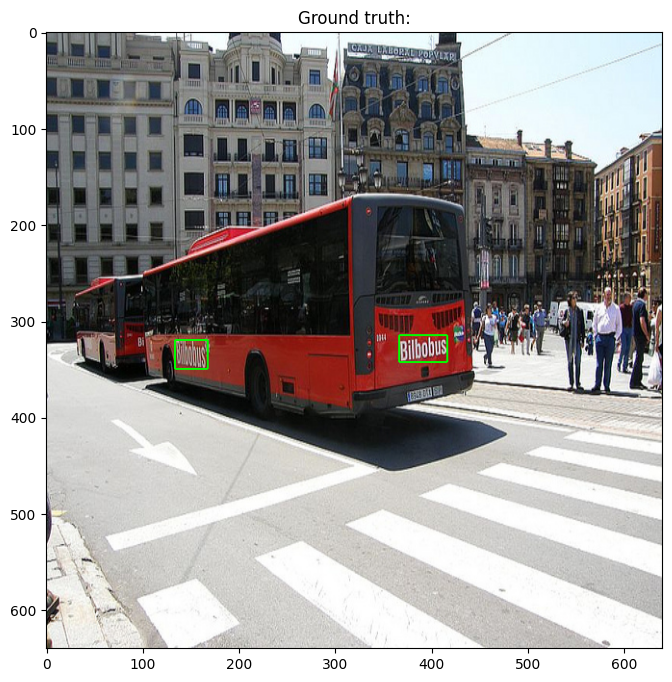

In [26]:
plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(yp[0, :3, 0]), rnd(yp[0, :3, 1]), rnd(yp[0, :3, 2]), rnd(yp[0, :3, 3]) 
))
plt.title('Predicted:')
plt.show()
plt.imshow(draw_boxes(
    x.permute(1, 2, 0).numpy(), rnd(y[:, 0]), rnd(y[:, 1]), rnd(y[:, 2]), rnd(y[:, 3]) 
))
plt.title('Ground truth:')
plt.show()

In [27]:
print(yp[0][:2], y[:2])

tensor([[329.0056, 391.8647,  29.0943,  50.3812,   1.0000,   0.9876],
        [334.8767, 151.3100,  33.9827,  34.3198,   1.0000,   0.9808]]) tensor([[334.7333, 151.4000,  31.3333,  33.6000,   1.0000,   1.0000],
        [328.8000, 391.9500,  28.8000,  49.7000,   1.0000,   1.0000]])


## Saving to json

In [28]:
#net = torch.load('centernet_resnet34_640.pth')

In [29]:
def postprocess(data, target_shape, input_shape):
    unf = {}
    res = data[data[:, -1] != 0]
    boxes = res[:, :4].copy()
    b = boxes.copy()
    result_boxes = np.zeros_like(boxes)
    result_boxes[:, 0] = (boxes[:, 1] - b[:, 3] / 2) * (target_shape[1] / input_shape[1])
    result_boxes[:, 1] = (boxes[:, 0] - b[:, 2] / 2) * (target_shape[0] / input_shape[0])
    result_boxes[:, 2] = boxes[:, 3] * (target_shape[1] / input_shape[1])
    result_boxes[:, 3] = boxes[:, 2] * (target_shape[0] / input_shape[0])
    unf['boxes'] = result_boxes
    unf['scores'] = res[:, -1]
    return unf


def extract_results():
    prepared_preds = []
    img_ids = []

    net.eval()

    for num, img_id in enumerate(tqdm(ds_val.ids)):
        img_id = int(img_id)
        img_meta = ct.loadImgs(ids=[img_id])[0]

        with torch.no_grad():
            x = ds_val[num][0]
            
            pred = net(
                x[None, ...].to(device),
                return_objects=True
            )[0].detach().cpu().numpy()
            prepared_preds.append(
                postprocess(pred, target_shape=(img_meta['height'], img_meta['width']), input_shape=input_shape)
            )
            img_ids.append(img_id)

    scores = np.concatenate([u['scores'] for u in prepared_preds], axis=0)
    boxes = np.concatenate([u['boxes'] for u in prepared_preds], axis=0)
    
    image_ids = []
    
    for num, i in enumerate(img_ids):
        image_ids += [i] * len(prepared_preds[num]['boxes'])
    image_ids = np.array(image_ids)

    dump_detections_to_cocotext_json(
        image_ids = image_ids.tolist(),
        xlefts=boxes[:, 0].tolist(),
        ytops=boxes[:, 1].tolist(),
        widths=boxes[:, 2].tolist(),
        heights=boxes[:, 3].tolist(),
        scores=scores.tolist(),
        path=f'predictions.json'
    )
    
    ap, prec, rec = evaluate_ap_from_cocotext_json(
    coco_text=ct,
    path=f'predictions.json'
    )
    return (ap, prec, rec, len(scores))

# Best AP

100%|████████████████████████████████████████████████████████████████████| 4446/4446 [01:26<00:00, 51.60it/s]


Loading and preparing results...     
DONE (t=0.19s)
Итоговый скор AP на val: 0.3392463731176474


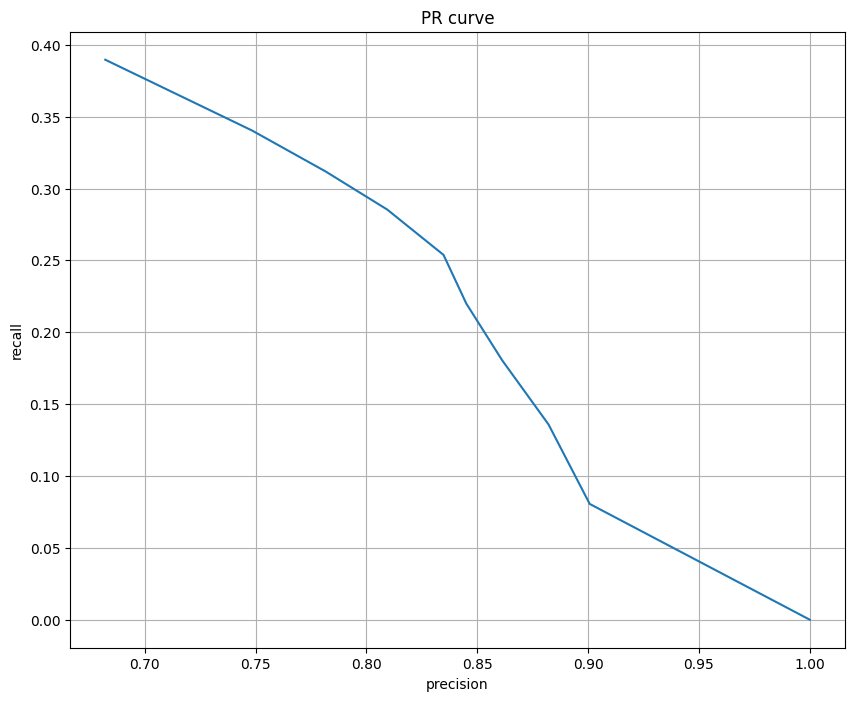

In [30]:
ap, prec, rec, n_obj = extract_results()

print(f"Итоговый скор AP на val: {ap}")

plt.plot(prec, rec)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('PR curve')
plt.grid()

In [31]:
n_obj

10601

In [ ]:
rec